In [1]:
#packages 
import numpy as np
from numpy import sin, cos
import matplotlib.pyplot as plt  
import csv
import timeit # timer 

plt.rcParams['figure.figsize'] = [9, 7]

# System Dynamics

In [2]:
# System Parameters - from user guide
g = 9.81        # m/s**2 - gravity
Rm = 8.4        # ohms - terminal resistance
Kt = 0.042      # N-m/A - torque const
Km = 0.042      # V/rad/s - motor back emf const
mr = 0.095      # kg - rotary arm mass
Lr = 0.085      # m - rotary arm length
mp = 0.024      # kg - pendulum mass
Lp = 0.129      # m - pendulum length

# Moment of inertia - rod about end
Jp = (1/3)*mp*Lp*Lp
Jr = (1/3)*mr*Lr*Lr

# Damping - idk put a function here later, maybe move into dynamics if it depends on current val
Dr = 0
Dp = 0

In [3]:
def pendulum_dynamics(current_state, input_voltage):
    """
    System equations for dynamics of rotary pendulum
    INPUTS:
    current_state - current state
    input_voltage - control input to apply
    OUTPUTS:
    state_dot - derivative of current state
    """
    x1, x2, x3, x4 = current_state
    Vm = input_voltage

    x1_dot = x3
    x2_dot = x4
    x3_dot = -(2*(8*Dr*Jp*Rm*x3 - 2*Kt*Lp**2*Vm*mp - 8*Jp*Kt*Vm + 8*Jp*Km*Kt*x3 + 2*Dr*Lp**2*Rm*mp*x3 + 2*Km*Kt*Lp**2*mp*x3 + Lp**3*Lr*Rm*mp**2*x4**2*sin(x2) + 4*Dp*Lp*Lr*Rm*mp*x4*cos(x2) - Lp**3*Lr*Rm*mp**2*x3**2*cos(x2)**2*sin(x2) - 2*Lp**2*Lr*Rm*g*mp**2*cos(x2)*sin(x2) + 4*Jp*Lp*Lr*Rm*mp*x4**2*sin(x2) + Lp**4*Rm*mp**2*x3*x4*cos(x2)*sin(x2) + 4*Jp*Lp**2*Rm*mp*x3*x4*cos(x2)*sin(x2)))/(Rm*(Lp**4*mp**2 + 16*Jp*Jr - Lp**4*mp**2*cos(x2)**2 + 4*Lp**2*Lr**2*mp**2 + 4*Jp*Lp**2*mp + 16*Jp*Lr**2*mp + 4*Jr*Lp**2*mp - 4*Lp**2*Lr**2*mp**2*cos(x2)**2 - 4*Jp*Lp**2*mp*cos(x2)**2))
    x4_dot = -(16*Dp*Jr*Rm*x4 - 2*Lp**3*Rm*g*mp**2*sin(x2) + 4*Dp*Lp**2*Rm*mp*x4 + 16*Dp*Lr**2*Rm*mp*x4 - 8*Jr*Lp*Rm*g*mp*sin(x2) + Lp**4*Rm*mp**2*x3**2*cos(x2)**3*sin(x2) + 2*Lp**3*Rm*g*mp**2*cos(x2)**2*sin(x2) - 4*Dp*Lp**2*Rm*mp*x4*cos(x2)**2 - Lp**4*Rm*mp**2*x3**2*cos(x2)*sin(x2) - 8*Lp*Lr**2*Rm*g*mp**2*sin(x2) - 8*Kt*Lp*Lr*Vm*mp*cos(x2) + 8*Dr*Lp*Lr*Rm*mp*x3*cos(x2) + 8*Km*Kt*Lp*Lr*mp*x3*cos(x2) - 4*Lp**2*Lr**2*Rm*mp**2*x3**2*cos(x2)*sin(x2) + 4*Lp**2*Lr**2*Rm*mp**2*x4**2*cos(x2)*sin(x2) - 4*Jr*Lp**2*Rm*mp*x3**2*cos(x2)*sin(x2) + 4*Lp**3*Lr*Rm*mp**2*x3*x4*cos(x2)**2*sin(x2))/(Rm*(Lp**4*mp**2 + 16*Jp*Jr - Lp**4*mp**2*cos(x2)**2 + 4*Lp**2*Lr**2*mp**2 + 4*Jp*Lp**2*mp + 16*Jp*Lr**2*mp + 4*Jr*Lp**2*mp - 4*Lp**2*Lr**2*mp**2*cos(x2)**2 - 4*Jp*Lp**2*mp*cos(x2)**2))

    state_dot = np.array([x1_dot, x2_dot, x3_dot, x4_dot])

    return state_dot

In [17]:
def rk4_integrate(current_state, input_voltage, h):
    """
    Runge–Kutta method of integration
    INPUTS:
    current_state - current state: x1, x2, x3, x4
    input_voltage - control input
    h - time step
    OUTPUTS:
    rk4_sol - new state
    """
    
    k1 = pendulum_dynamics(current_state, input_voltage)
    k2 = pendulum_dynamics(current_state + h*k1/2, input_voltage)
    k3 = pendulum_dynamics(current_state + h*k2/2, input_voltage)
    k4 = pendulum_dynamics(current_state + h*k3, input_voltage)
    
    rk4_sol = current_state + (h/6)*(k1+2*k2+2*k3+k4)
    
    return rk4_sol

# Cost Function

In [5]:
def cost_function(current_state, control):
    """
    Cost Function for MPC
    INPUTS: 
    current_state - array of state position
    control - int of control voltage being applied
    OUTPUTS:
    cost - cost function value for given inputs
    """
    x1, x2, x3, x4 = current_state
    cost = 6*(x1**2)*(2*(sin(x1/3)**2) + (cos(x2/2)**2)) + 3*(x2**2)*(2*((cos(x1/3))**2) + 25*np.exp(-(x2/2.5)**2)) + 0.05*x3**2 + 0.1*x4**2 + 0.5*control**2
    if abs(x1)> np.deg2rad(135):
        cost += 100
    return cost

# IDP Functions

In [6]:
def uniform_input_grid(control_policy, M, region_size, prediction_horizon, u_limit):
    """
    Generate Uniform Control Grid
    INPUTS:
    control_policy - current control policy 
    M - number of u values to test
    region_size - size of region to draw u values from
    prediction_horizon - length of prediction horizon
    u_limit - limit of allowable values of u
    OUTPUTS:
    u_test_val_matrix - control grid to test    
    """    
    
    if len(control_policy) < prediction_horizon:
        control_policy = np.append(control_policy, np.zeros(prediction_horizon - len(control_policy)))
    
    u_test_val_matrix = np.zeros((prediction_horizon, M))   
    
    
    for i in range(prediction_horizon):
    
        # check the region size around the point        
        if (abs(control_policy[i]) + abs(region_size/2)) > u_limit:
            region_val_pos = min(u_limit - control_policy[i], region_size - u_limit + abs(control_policy[i]))
            region_val_neg = region_size - region_val_pos
            u_pos = np.linspace(control_policy[i], control_policy[i]+region_val_pos, int(np.ceil(M/2)))
            u_neg = np.linspace(control_policy[i]-region_val_neg, control_policy[i], int(np.ceil(M/2)))
            u_test_val_matrix[i] = np.append(u_neg, u_pos[1:])
        else: 
            u_test_val_matrix[i] = np.linspace(control_policy[i] - region_size/2, control_policy[i] + region_size/2, M)
            
    return u_test_val_matrix

In [7]:
def random_input_grid(control_policy, M, region_size, prediction_horizon, u_limit):
    """
    Generate Random Control Grid
    control_policy - current control policy 
    M - number of u values to test
    region_size - size of region to draw u values from
    prediction_horizon - length of prediction horizon
    u_limit - limit of allowable values of u
    OUTPUTS:
    u_test_val_matrix - control grid to test    
    """    
    if len(control_policy) < prediction_horizon:
        control_policy = np.append(control_policy, np.zeros(prediction_horizon - len(control_policy)))
    
    u_test_val_matrix = np.zeros((prediction_horizon, M))
    
    for i in range(prediction_horizon):
        
        if (abs(control_policy[i]) + abs(region_size/2)) > u_limit:
            
            region_val_pos = min(u_limit - control_policy[i], region_size - u_limit + abs(control_policy[i]))
            region_val_neg = region_size - region_val_pos
            
            # random numbers [-1, 1]
            rand_num = np.random.uniform(low = -1, high = 1, size=M)
            
            for j in range(M):
                if rand_num[j] > 0:
                    u_test_val_matrix[i,j] = control_policy[i] + rand_num[j]*region_val_pos
                else:
                    u_test_val_matrix[i,j] = control_policy[i] + rand_num[j]*region_val_neg
        else:             
            D = np.diag(np.random.uniform(low = -1, high = 1, size=M))
            u_test_val_matrix[i] = control_policy[i] + np.matmul(region_size/2*np.ones(M), D)
        
    return u_test_val_matrix

In [8]:
def trajectories(initial_state, control_grid_values, time_step):
    """
    Calculate trajectories and costs for given initial state and u grid
    INPUTS:
    initial_state - state which to start trajectories from 
    control_grid_values - array of u values to test at each time step
    time_step - sampling instant
    OUTPUTS:
    state_trajectories - array calculated trajectory
    cost_values- corresponding array of costs
    input_values - u grid values
    """
    
    prediction_horizon = np.shape(control_grid_values)[0]
    M = np.shape(control_grid_values)[1]
    
    # arrays for storage 
    state_trajectories = np.zeros((prediction_horizon, M, 4))
    cost_values = np.zeros((prediction_horizon, M))
    input_values = np.zeros((prediction_horizon, M))
    
    for i in range(M):
        state = initial_state
        
        for j in range(prediction_horizon):
            # calculate the trajectories for each u test value 
            
            state_trajectories[j, i, :] = state
            
            # u value from test
            control_val = control_grid_values[j, i]
            
            input_values[j, i] = control_val
            
            cost_values[:j+1,i] += cost_function(state, control_val)
            
            state = rk4_integrate(state, control_val, time_step)
    
    return state_trajectories, cost_values, input_values

In [9]:
def closest_state(state, state_trajectories, stage):
    """
    Finding Closest State
    INPUTS:
    state - state searching for the closest state to
    state_trajectories - matrix of all state trajectories calculated
    stage - current stage value
    OUTPUTS:
    index_1, index_2 - array location of closest state
    """
    
    min_diff = 1e10
    
    x1, x2, x3, x4 = state
    
    for i in range(stage, np.shape(state_trajectories)[0]):
        # only from future // already calculated results
        
        for j in range(np.shape(state_trajectories)[1]):
            # across all trajectories 
            y1, y2, y3, y4 = state_trajectories[i, j, :]
            
            difference = (x1-y1)**2 + (x2-y2)**2 + (x3-y3)**2 + (x4-y4)**2
            
            if difference < min_diff:
                min_diff = difference
                index_1 = i
                index_2 = j
    
    return index_1, index_2
    

In [10]:
def find_next_optimal(state_trajectories, cost_values, control_grid_values, time_step):
    """
    Find the optimal control law to apply given state trajectories
    INPUTS:
    state_trajectories - array of all state trajectories calculated
    cost_values - array of cost of state trajectories
    control_grid_values - array of control values to test for each sampling instant
    time_step - sampling instant
    OUTPUTS:
    optimal_control_law - array of optimal control law to apply
    optimal_control_cost - array of the costs generated with the optimal control law
    state -
    """
    
    prediction_horizon = np.shape(control_grid_values)[0]
    M = np.shape(control_grid_values)[1]

    for i in range(1, prediction_horizon+1):

        temp_u = np.zeros(M)
        temp_cost = np.zeros(M)
    
        for n in range(len(state_trajectories[-i, :, :])):        
            initial_state = state_trajectories[-i, n, :]
            u_test_values = control_grid_values[-i]
            
            min_cost = 1e10
            
            for m in range(M):
                # each test value for u 
                state = rk4_integrate(initial_state, u_test_values[m], time_step)
                cost = cost_function(state, u_test_values[m])                
                j=0
                for j in range(i-1):
                    # find it's closest state
                    close_state = closest_state(state, state_trajectories, prediction_horizon+1-i+j)
                    
                    # apply that state's best control 
                    control = control_grid_values[close_state]
                    state = rk4_integrate(state, control, time_step)
                    cost += cost_function(state, control)
                
                if cost < min_cost:
                    min_cost = cost 
                    temp_u[n] = u_test_values[m]
                    temp_cost[n] = cost

            
        control_grid_values[-i] = temp_u

        cost_values[-i] = temp_cost

    
    #finding the optimal from here:
    state = initial_state
    optimal_control_law = np.zeros(prediction_horizon)
    optimal_control_cost = 0
    
    for i in range(prediction_horizon):
        close_state = closest_state(state, state_trajectories, i)
        optimal_control_law[i] = control_grid_values[close_state]
        state = rk4_integrate(state, optimal_control_law[i], 0.025)
        optimal_control_cost += cost_function(state, optimal_control_law[i])
    
    return optimal_control_law, optimal_control_cost, state

In [11]:
def iteration(initial_state, control_policy, prediction_horizon, M, 
              region_size, u_limit, contraction_constant, max_iterations, 
              time_step): 
    
    # set initial policy 
    optimal_control_law = control_policy
    
    for k in range(max_iterations):
        
        u_test = random_input_grid(optimal_control_law, M, region_size, prediction_horizon, u_limit)
                
        state_trajectories, cost_values, input_values = trajectories(initial_state, u_test, time_step)
        
        optimal_control_law, optimal_control_cost, final_state = find_next_optimal(state_trajectories, cost_values, input_values, time_step)
        
        # back to algorithm - reduce region size
        region_size = contraction_constant*region_size
        
    return optimal_control_law

# Plots for Moving Window NMPC

In [12]:
def plot_simulation_results(sim_states, sim_controls, time_step):
    """
    Take simulation output arrays and makes nice plot of arm angle, pendulum angle and 
    control value (attmpting first order hold)
    """
    time_array = np.zeros(len(sim_controls))
    
    for i in range(len(sim_controls)):
        time_array[i] = time_step*i
        
    time_array_control = np.zeros((len(time_array), 2))
    control_double = np.zeros((len(time_array), 2))
    
    for i in range(len(time_array)):
        time_array_control[i] = (i*time_step, (i+1)*time_step-0.001)
        control_double[i] = (sim_controls[i], sim_controls[i])
        
    time_array_control = time_array_control.flatten()    
    control_double = control_double.flatten()
    
    smallest_rotation = int(np.ceil(min(sim_states[:,1])/(2*np.pi)))
    largest_rotation = int(np.floor(max(sim_states[:,1])/(2*np.pi)))
    
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
    
    # arm rotation plot
    ax1.plot(time_array, np.rad2deg(sim_states[:, 0]))
    ax1.set(xlabel='Time - (sec)', ylabel='Theta - (deg)', title='Arm Rotation')
    ax1.grid()
    ax1.axhline(-135, color = 'red', linestyle = 'dashed')
    ax1.axhline(135, color = 'red', linestyle = 'dashed')
    
    # pendulum rotation plot
    ax2.plot(time_array, np.rad2deg(sim_states[:, 1]))
    ax2.set(xlabel='Time - (sec)', ylabel='Alpha - (deg)', title='Pendulum Angle')
    ax2.grid()
    #ax2.axhline(180, color = 'black', linestyle =  (0, (3, 10, 1, 10)))
    for i in range(smallest_rotation, largest_rotation + 1):
        ax2.axhline(360*i, color = 'red', linestyle = 'dashed')
    
    # control volt plot
    ax3.plot(time_array_control, control_double)
    ax3.set(xlabel='Time - (sec)', ylabel='Control - (Volts)', title='Control')
    ax3.grid()
    ax3.axhline(-18, color = 'red', linestyle = 'dashed')
    ax3.axhline(18, color = 'red', linestyle = 'dashed')
    
    plt.show()

# "Static" NMPC Simulation

Last 3 inputs have default:

- print_progress = False -- prints "Time x: [x, x, x, x]"
- export_data = False
- file_name = None - must be given as 'name.csv'

If export_data = True and no file_name given, adds to 'simulation.csv'

In [13]:
def static_simulation(sim_time, time_step, initial_state, control_policy, 
               print_progress = False, export_data = False, file_name = None):
    """Create a doc string"""
    simulation_start_time = timeit.default_timer()
    
    if export_data:
        # set up values to be exported to csv in readable form
        if file_name == None:
            file_name = 'simulation.csv'        
        try:
            # try to open a new file 
            open(file_name, 'x', newline = '') 
        except FileExistsError:
            # file already exists
            headers_needed = False
        else:
            # needs a new file 
            headers_needed = True      
        
        f = open(file_name, 'a', newline = '') #'a' append to existing file 
        writer = csv.writer(f)

        if headers_needed:
            # write headings for parameters of interest
            writer.writerow(['time', 'theta', 'alpha', 'theta_dot', 'alpha_dot', 'control', 'stage_cost','calc_time'])
    
    # initial states
    next_state = initial_state
    next_optimal_policy = control_policy
    
    # how many windows to operate on 
    time_windows = int(np.floor(sim_time/time_step)) + 1
    
    # storage array 
    state_history = np.zeros((time_windows, 4))
    control_history = np.zeros(time_windows)
    
    for i in range(time_windows):
        
        if print_progress:
            # print in terminal 
            print(f'Time {i*time_step:.3f}:', np.array_str(next_state, precision=3, suppress_small=True))
            if i == time_windows - 1:
                print("Finished, time taken: ", np.round(timeit.default_timer() - simulation_start_time, 3))
            
        #save state
        state_history[i] = next_state
        
        # constant for all alpha 
        M = 3
        u_limit = 18
        u_range = 12
        contraction = 0.8
        pred_horizon = 25
        
        #find control
        if i == 0: # on first time step
            iterations = 15
        
        else:
            iterations = 5 

        # timer - just measuring opt control algorithm time
        starttime = timeit.default_timer()
        
        optimal_control_policy = iteration(next_state, next_optimal_policy, pred_horizon, M, 
                                           u_range, u_limit, contraction, iterations, time_step)
        stoptime = timeit.default_timer()
        
        #save best control
        control_history[i] = optimal_control_policy[0]
        
        if export_data:
            # save in csv
            stage_cost = cost_function(next_state, control_history[i])
            
            export_array = np.append(np.append(time_step*i, next_state), 
                                     np.array([control_history[i], stage_cost, stoptime - starttime]))
            writer.writerow(export_array)        
        
        #find next state and new control
        next_state = rk4_integrate(next_state, optimal_control_policy[0], time_step)
        # creates dulplicate last value for input control array
        next_optimal_policy = np.append(optimal_control_policy[1:], optimal_control_policy[-1:])
    
    # after simulation - record total time and close csv writer
    if export_data:
        f.close()
    
    return state_history, control_history

Simulation Number: 0


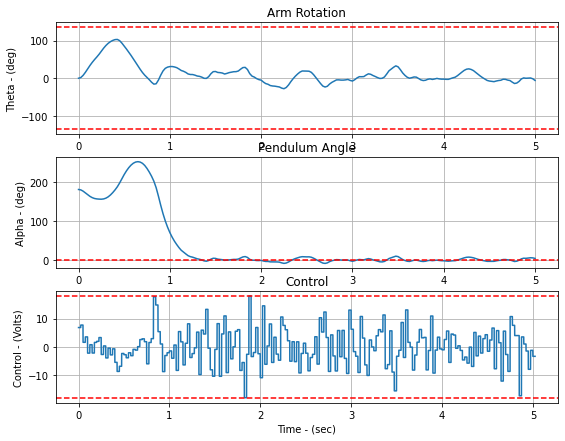

Simulation Number: 1


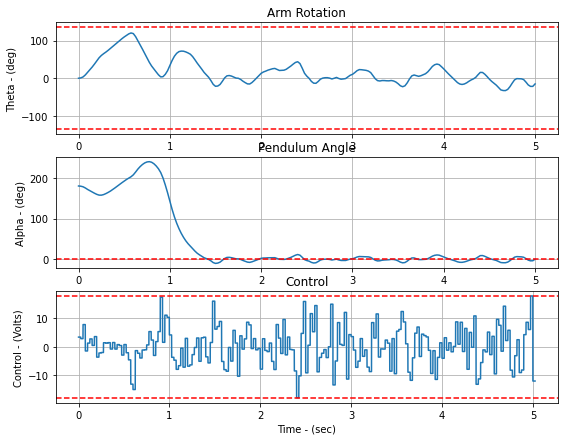

Simulation Number: 2


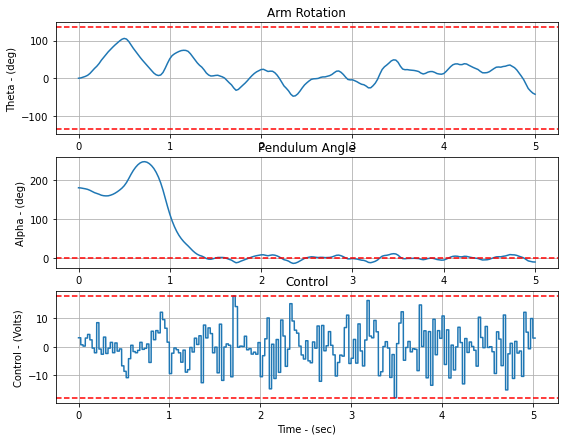

Simulation Number: 3


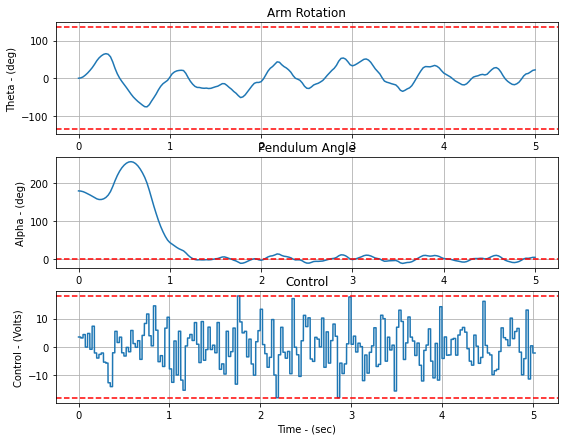

Simulation Number: 4


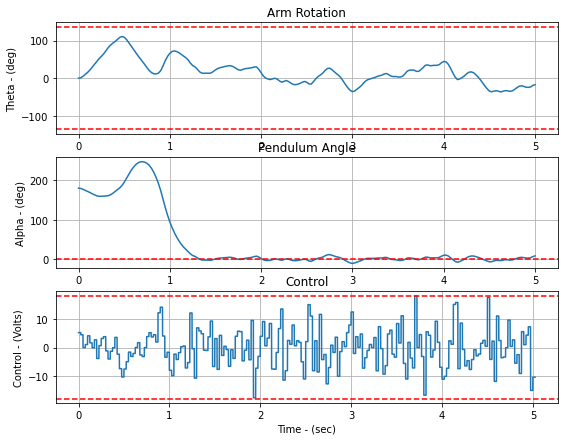

In [14]:
sim_time = 5
init_state = np.array([0, np.pi, 0, 0])
init_policy = np.zeros(10)
time_step = 0.025

for repeat_count in range(5):
    sim_states, sim_controls = static_simulation(sim_time, time_step, init_state, init_policy, False, True, 'temp.csv')
    print("Simulation Number:", repeat_count)
    plot_simulation_results(sim_states, sim_controls, 0.025)

# "Dynamic" NMPC Simulation

Last 3 inputs have default:

- print_progress = False -- prints "Time x: [x, x, x, x]"
- export_data = False
- file_name = None - must be given as 'name.csv'

If export_data = True and no file_name given, adds to 'simulation.csv'

In [15]:
def dynamic_simulation(sim_time, time_step, initial_state, control_policy, 
               print_progress = False, export_data = False, file_name = None):
    """Create a doc string"""
    simulation_start_time = timeit.default_timer()
    
    if export_data:
        # set up values to be exported to csv in readable form
        if file_name == None:
            file_name = 'simulation.csv'        
        try:
            # try to open a new file 
            open(file_name, 'x', newline = '') 
        except FileExistsError:
            # file already exists
            headers_needed = False
        else:
            # needs a new file 
            headers_needed = True      
        
        f = open(file_name, 'a', newline = '') #'a' append to existing file 
        writer = csv.writer(f)

        if headers_needed:
            # write headings for parameters of interest
            writer.writerow(['time', 'theta', 'alpha', 'theta_dot', 'alpha_dot', 'control', 'stage_cost','calc_time'])
    
    # initial states
    next_state = initial_state
    next_optimal_policy = control_policy
    
    # how many windows to operate on 
    time_windows = int(np.floor(sim_time/time_step)) + 1
    
    # storage array 
    state_history = np.zeros((time_windows, 4))
    control_history = np.zeros(time_windows)
    
    #equal for all intervals
    contraction = 0.8
    M = 3
    
    for i in range(time_windows):
        
        if print_progress:
            # print in terminal 
            print(f'Time {i*time_step:.3f}:', np.array_str(next_state, precision=3, suppress_small=True))
            if i == time_windows - 1:
                print("Finished, time taken: ", np.round(timeit.default_timer() - simulation_start_time, 3))
            
        #save state
        state_history[i] = next_state
        
        if abs(next_state[1]) <= (1/36)*np.pi:   # 5 deg
            pred_horizon = 15
            iterations = 3
            u_limit = 12
            u_range = 3
            
        elif abs(next_state[1]) <= (1/12)*np.pi: # 15 deg
            pred_horizon = 15
            iterations = 5
            u_limit = 12
            u_range = 3 
        
        elif abs(next_state[1]) <= (2/3)*np.pi:  # 120 deg
            pred_horizon = 10
            iterations = 5
            u_limit = 18
            u_range = 12
            
        else: # greater than 120 deg
            pred_horizon = 25
            u_limit = 18
            u_range = 12
            
            if i == 0: # on first time step
                iterations = 15
            else:
                iterations = 5

        # timer - just measuring opt control algorithm time
        starttime = timeit.default_timer()
        
        optimal_control_policy = iteration(next_state, next_optimal_policy, pred_horizon, M, 
                                           u_range, u_limit, contraction, iterations, time_step)
        stoptime = timeit.default_timer()
        
        #save best control
        control_history[i] = optimal_control_policy[0]
        
        if export_data:
            # save in csv
            stage_cost = cost_function(next_state, control_history[i])
            
            export_array = np.append(np.append(time_step*i, next_state), 
                                     np.array([control_history[i], stage_cost, stoptime - starttime]))
            writer.writerow(export_array)        
        
        #find next state and new control
        next_state = rk4_integrate(next_state, optimal_control_policy[0], time_step)
        # creates dulplicate last value for input control array
        next_optimal_policy = np.append(optimal_control_policy[1:], optimal_control_policy[-1:])
    
    # after simulation close csv writer
    if export_data:
        f.close()

    return state_history, control_history

Simulation Number: 0


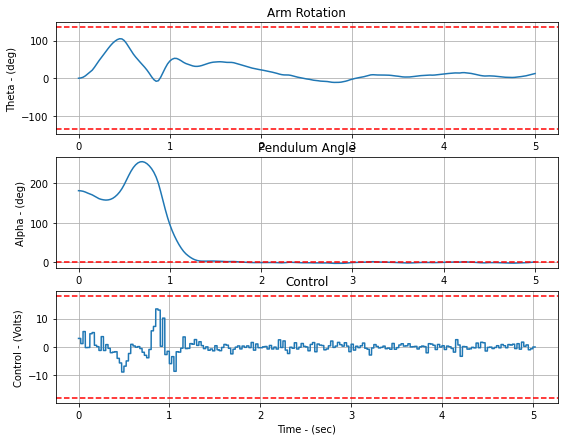

Simulation Number: 1


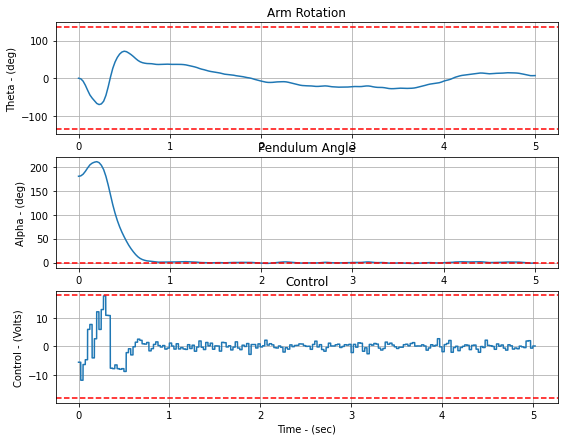

Simulation Number: 2


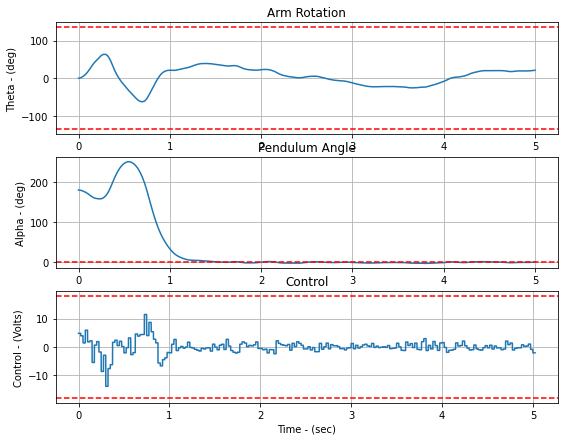

Simulation Number: 3


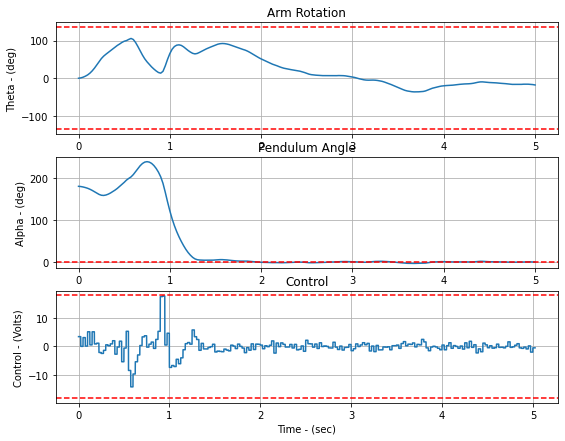

Simulation Number: 4


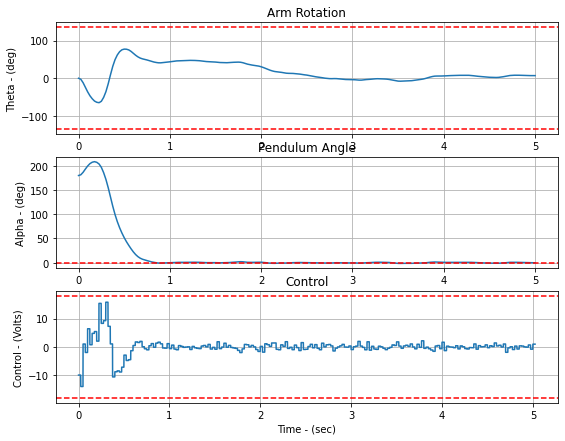

In [18]:
sim_time = 5
init_state = np.array([0, np.pi, 0, 0])
init_policy = np.zeros(10)
time_step = 0.025

for repeat_count in range(5):
    sim_states, sim_controls = dynamic_simulation(sim_time, time_step, init_state, init_policy, False, True, 'dynamic_results.csv')
    print("Simulation Number:", repeat_count)
    plot_simulation_results(sim_states, sim_controls, 0.025)